In [0]:
# Copyright 2019 Google Inc.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

Please note that the following code is referencing and resuing from this link
[Predicting Movie Reivew](https://colab.research.google.com/github/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb#scrollTo=xiYrZKaHwV81) and here we only modified some parts of the code to meet our own academic purpose.

#Predicting Restaurant Review Sentiment with BERT on TF Hub

## Install necessary libraries

Train a model to predict whether an Yelp review is positive or negative using BERT in Tensorflow with tf hub.

In [0]:
!pip install tensorflow==1.14.0
from sklearn.model_selection import train_test_split
from datetime import datetime
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub

     |████████████████████████████████| 109.2MB 95kB/s 
     |████████████████████████████████| 491kB 35.1MB/s 
     |████████████████████████████████| 3.2MB 40.2MB/s 
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow 2.2.0rc4
    Uninstalling tensorflow-2.2.0rc4:
      Successfully uninstalled tensorflow-2.2.0rc4


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [0]:
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import tarfile
import os
import re

In [0]:
!pip install bert-tensorflow
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

     |████████████████████████████████| 71kB 4.0MB/s 



Below, we'll set an output directory location to store our model output and checkpoints. This can be a local directory, in which case you'd set OUTPUT_DIR to the name of the directory you'd like to create. If you're running this code in Google's hosted Colab, the directory won't persist after the Colab session ends.

In [0]:
# Set the output directory for saving model file
# Optionally, set a GCP bucket location

OUTPUT_DIR = 'BERT'#@param {type:"string"}
#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = False #@param {type:"boolean"}

if DO_DELETE:
  try:
    tf.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    # Doesn't matter if the directory didn't exist
    pass
tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))


***** Model output directory: BERT *****


##Loading Data

We are using Yelp Polarity dataset from here [Yelp reviews - Polarity](https://course.fast.ai/datasets). There contains 1,569,264 samples from the Yelp Dataset Challenge 2015. This subset has 280,000 training samples and 19,000 test samples in each polarity.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data_tg = tarfile.open('/content/drive/My Drive/data/yelp_review_polarity_csv.tgz')
data_tg.extractall('data')
data_tg.close()

In [0]:
train_df = pd.read_csv('data/yelp_review_polarity_csv/train.csv', header=None)
train_df.head()

0                                                  1
0  1  Unfortunately, the frustration of being Dr. Go...
1  2  Been going to Dr. Goldberg for over 10 years. ...
2  1  I don't know what Dr. Goldberg was like before...
3  1  I'm writing this review to give you a heads up...
4  2  All the food is great here. But the best thing...

In [0]:
test_df = pd.read_csv('data/yelp_review_polarity_csv/test.csv', header=None)
test_df.head()

0                                                  1
0  2  Contrary to other reviews, I have zero complai...
1  1  Last summer I had an appointment to get new ti...
2  2  Friendly staff, same starbucks fair you get an...
3  1  The food is good. Unfortunately the service is...
4  2  Even when we didn't have a car Filene's Baseme...

In [0]:
train_df[0] = (train_df[0] == 2).astype(int)
test_df[0] = (test_df[0] == 2).astype(int)

In [0]:
test_df.columns = ['polarity', 'sentence']
train_df.columns = ['polarity', 'sentence']
test_df.head()

polarity                                           sentence
0         1  Contrary to other reviews, I have zero complai...
1         0  Last summer I had an appointment to get new ti...
2         1  Friendly staff, same starbucks fair you get an...
3         0  The food is good. Unfortunately the service is...
4         1  Even when we didn't have a car Filene's Baseme...

In [0]:
train = train_df
test = test_df

In [0]:
train = train.sample(5000)
test = test.sample(500)

In [0]:
train.head()

polarity                                           sentence
54064          1  I would recommend this family owned business a...
329132         1  There are two places in Pittsburgh for Asian p...
57839          0  I don't think this place deserves four stars. ...
5739           0  Nice employees, nice location, Awful sushi.  S...
382566         1  My girlfriends brought me here for my birthday...

In [0]:
test.head()

polarity                                           sentence
24216         0  Ok I just moved into the area and came into Ku...
21741         0  Went to naked fish happy hour. Really bad bad ...
529           1  I can only comment on carry out. \n\nI have or...
21373         1  Great food    omelettes are huge so we split o...
20259         0  I hate their layout so much I avoid the store ...

For us, our input data is the 'sentence' column and our label is the 'polarity' column (0, 1 for negative and positive, respecitvely)

In [0]:
DATA_COLUMN = 'sentence'
LABEL_COLUMN = 'polarity'
# label_list is the list of labels, i.e. True, False or 0, 1 or 'dog', 'cat'
label_list = [0, 1]

##Data Preprocessing
We'll need to transform our data into a format BERT understands. This involves two steps. First, we create  `InputExample`'s using the constructor provided in the BERT library.

- `text_a` is the text we want to classify, which in this case, is the `Request` field in our Dataframe. 
- `text_b` is used if we're training a model to understand the relationship between sentences (i.e. is `text_b` a translation of `text_a`? Is `text_b` an answer to the question asked by `text_a`?). This doesn't apply to our task, so we can leave `text_b` blank.
- `label` is the label for our example, i.e. True, False

In [0]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_InputExamples = test.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [0]:
train_InputExamples.head()

54064     <bert.run_classifier.InputExample object at 0x...
329132    <bert.run_classifier.InputExample object at 0x...
57839     <bert.run_classifier.InputExample object at 0x...
5739      <bert.run_classifier.InputExample object at 0x...
382566    <bert.run_classifier.InputExample object at 0x...
dtype: object

Next, we need to preprocess our data so that it matches the data BERT was trained on. For this, we'll need to do a couple of things (but don't worry--this is also included in the Python library):

1. Lowercase our text (if we're using a BERT lowercase model)
2. Tokenize it (i.e. "sally says hi" -> ["sally", "says", "hi"])
3. Break words into WordPieces (i.e. "calling" -> ["call", "##ing"])
4. Map our words to indexes using a vocab file that BERT provides
5. Add special "CLS" and "SEP" tokens (see the [readme](https://github.com/google-research/bert))
6. Append "index" and "segment" tokens to each input (see the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))




To start, we'll need to load a vocabulary file and lowercasing information directly from the BERT tf hub module:

In [0]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Using our tokenizer, we'll call `run_classifier.convert_examples_to_features` on our InputExamples to convert them into features BERT understands.

In [0]:
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 5000


INFO:tensorflow:Writing example 0 of 5000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i would recommend this family owned business as i have taken multiple garments for various alterations , and could not be more pleased with their service . the staff is super friendly ! [SEP]


INFO:tensorflow:tokens: [CLS] i would recommend this family owned business as i have taken multiple garments for various alterations , and could not be more pleased with their service . the staff is super friendly ! [SEP]


INFO:tensorflow:input_ids: 101 1045 2052 16755 2023 2155 3079 2449 2004 1045 2031 2579 3674 21902 2005 2536 16705 1010 1998 2071 2025 2022 2062 7537 2007 2037 2326 1012 1996 3095 2003 3565 5379 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1045 2052 16755 2023 2155 3079 2449 2004 1045 2031 2579 3674 21902 2005 2536 16705 1010 1998 2071 2025 2022 2062 7537 2007 2037 2326 1012 1996 3095 2003 3565 5379 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] there are two places in pittsburgh for asian people to get a hair ##cut . this is the better one . \ n \ ni came at 5 ##pm on a thursday , place was empty so i didn ' t have to wait . \ n \ nt ##he lady owner / st ##yl ##ist was very rec ##eptive and at ##ten ##tive to the hair style i wanted . sure , i wanted a standard asian fade but she carefully loomed at the photos i had on my phone . \ n \ nh ##ere is a huge bonus though ! she has a computer with tons of real photos of hair ##cut ##s so you can scroll through and choose the one you [SEP]


INFO:tensorflow:tokens: [CLS] there are two places in pittsburgh for asian people to get a hair ##cut . this is the better one . \ n \ ni came at 5 ##pm on a thursday , place was empty so i didn ' t have to wait . \ n \ nt ##he lady owner / st ##yl ##ist was very rec ##eptive and at ##ten ##tive to the hair style i wanted . sure , i wanted a standard asian fade but she carefully loomed at the photos i had on my phone . \ n \ nh ##ere is a huge bonus though ! she has a computer with tons of real photos of hair ##cut ##s so you can scroll through and choose the one you [SEP]


INFO:tensorflow:input_ids: 101 2045 2024 2048 3182 1999 6278 2005 4004 2111 2000 2131 1037 2606 12690 1012 2023 2003 1996 2488 2028 1012 1032 1050 1032 9152 2234 2012 1019 9737 2006 1037 9432 1010 2173 2001 4064 2061 1045 2134 1005 1056 2031 2000 3524 1012 1032 1050 1032 23961 5369 3203 3954 1013 2358 8516 2923 2001 2200 28667 22048 1998 2012 6528 6024 2000 1996 2606 2806 1045 2359 1012 2469 1010 1045 2359 1037 3115 4004 12985 2021 2016 5362 24358 2012 1996 7760 1045 2018 2006 2026 3042 1012 1032 1050 1032 18699 7869 2003 1037 4121 6781 2295 999 2016 2038 1037 3274 2007 6197 1997 2613 7760 1997 2606 12690 2015 2061 2017 2064 17186 2083 1998 5454 1996 2028 2017 102


INFO:tensorflow:input_ids: 101 2045 2024 2048 3182 1999 6278 2005 4004 2111 2000 2131 1037 2606 12690 1012 2023 2003 1996 2488 2028 1012 1032 1050 1032 9152 2234 2012 1019 9737 2006 1037 9432 1010 2173 2001 4064 2061 1045 2134 1005 1056 2031 2000 3524 1012 1032 1050 1032 23961 5369 3203 3954 1013 2358 8516 2923 2001 2200 28667 22048 1998 2012 6528 6024 2000 1996 2606 2806 1045 2359 1012 2469 1010 1045 2359 1037 3115 4004 12985 2021 2016 5362 24358 2012 1996 7760 1045 2018 2006 2026 3042 1012 1032 1050 1032 18699 7869 2003 1037 4121 6781 2295 999 2016 2038 1037 3274 2007 6197 1997 2613 7760 1997 2606 12690 2015 2061 2017 2064 17186 2083 1998 5454 1996 2028 2017 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i don ' t think this place deserves four stars . my friend took us here for lunch and i thought the food was just average . the chicken pan ##ang curry was just ok , nothing special . the crab papa ##ya salad was too salty . we asked the waiter for a whole catfish fried or bb ##q , i think he wasn ' t listening because what we got were deep - fried cut up catfish file ##ts . when we told him we wanted a whole catfish not file ##ts , he said they only had file ##ts . w ##th ? ? the only saving grace was the tom yu ##m soup and combination fried rice . those very great . [SEP]


INFO:tensorflow:tokens: [CLS] i don ' t think this place deserves four stars . my friend took us here for lunch and i thought the food was just average . the chicken pan ##ang curry was just ok , nothing special . the crab papa ##ya salad was too salty . we asked the waiter for a whole catfish fried or bb ##q , i think he wasn ' t listening because what we got were deep - fried cut up catfish file ##ts . when we told him we wanted a whole catfish not file ##ts , he said they only had file ##ts . w ##th ? ? the only saving grace was the tom yu ##m soup and combination fried rice . those very great . [SEP]


INFO:tensorflow:input_ids: 101 1045 2123 1005 1056 2228 2023 2173 17210 2176 3340 1012 2026 2767 2165 2149 2182 2005 6265 1998 1045 2245 1996 2833 2001 2074 2779 1012 1996 7975 6090 5654 15478 2001 2074 7929 1010 2498 2569 1012 1996 18081 13008 3148 16521 2001 2205 23592 1012 2057 2356 1996 15610 2005 1037 2878 23723 13017 2030 22861 4160 1010 1045 2228 2002 2347 1005 1056 5962 2138 2054 2057 2288 2020 2784 1011 13017 3013 2039 23723 5371 3215 1012 2043 2057 2409 2032 2057 2359 1037 2878 23723 2025 5371 3215 1010 2002 2056 2027 2069 2018 5371 3215 1012 1059 2705 1029 1029 1996 2069 7494 4519 2001 1996 3419 9805 2213 11350 1998 5257 13017 5785 1012 2216 2200 2307 1012 102


INFO:tensorflow:input_ids: 101 1045 2123 1005 1056 2228 2023 2173 17210 2176 3340 1012 2026 2767 2165 2149 2182 2005 6265 1998 1045 2245 1996 2833 2001 2074 2779 1012 1996 7975 6090 5654 15478 2001 2074 7929 1010 2498 2569 1012 1996 18081 13008 3148 16521 2001 2205 23592 1012 2057 2356 1996 15610 2005 1037 2878 23723 13017 2030 22861 4160 1010 1045 2228 2002 2347 1005 1056 5962 2138 2054 2057 2288 2020 2784 1011 13017 3013 2039 23723 5371 3215 1012 2043 2057 2409 2032 2057 2359 1037 2878 23723 2025 5371 3215 1010 2002 2056 2027 2069 2018 5371 3215 1012 1059 2705 1029 1029 1996 2069 7494 4519 2001 1996 3419 9805 2213 11350 1998 5257 13017 5785 1012 2216 2200 2307 1012 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] nice employees , nice location , awful su ##shi . should have known something was ami ##ss when it was empty at 6 : 30 on a friday night . surely there are better places in town . [SEP]


INFO:tensorflow:tokens: [CLS] nice employees , nice location , awful su ##shi . should have known something was ami ##ss when it was empty at 6 : 30 on a friday night . surely there are better places in town . [SEP]


INFO:tensorflow:input_ids: 101 3835 5126 1010 3835 3295 1010 9643 10514 6182 1012 2323 2031 2124 2242 2001 26445 4757 2043 2009 2001 4064 2012 1020 1024 2382 2006 1037 5958 2305 1012 7543 2045 2024 2488 3182 1999 2237 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 3835 5126 1010 3835 3295 1010 9643 10514 6182 1012 2323 2031 2124 2242 2001 26445 4757 2043 2009 2001 4064 2012 1020 1024 2382 2006 1037 5958 2305 1012 7543 2045 2024 2488 3182 1999 2237 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] my girlfriends brought me here for my birthday lunch . . food was great . . margarita ' s were even better ! especially the skinny margarita ( which i added grandma too and it became a \ " somewhat thin \ " margarita ) . lori our bartender was very patient with us . . which was so needed , as my g ##f ' s can be very high maintenance ! great atmosphere . . we people watched - which is always fun in vegas . \ n \ nt ##han ##ks for making my birthday lunch a fun time and thanks lori for being very at ##ten ##tive and giving us great service ! [SEP]


INFO:tensorflow:tokens: [CLS] my girlfriends brought me here for my birthday lunch . . food was great . . margarita ' s were even better ! especially the skinny margarita ( which i added grandma too and it became a \ " somewhat thin \ " margarita ) . lori our bartender was very patient with us . . which was so needed , as my g ##f ' s can be very high maintenance ! great atmosphere . . we people watched - which is always fun in vegas . \ n \ nt ##han ##ks for making my birthday lunch a fun time and thanks lori for being very at ##ten ##tive and giving us great service ! [SEP]


INFO:tensorflow:input_ids: 101 2026 27408 2716 2033 2182 2005 2026 5798 6265 1012 1012 2833 2001 2307 1012 1012 24570 1005 1055 2020 2130 2488 999 2926 1996 15629 24570 1006 2029 1045 2794 13055 2205 1998 2009 2150 1037 1032 1000 5399 4857 1032 1000 24570 1007 1012 18669 2256 15812 2001 2200 5776 2007 2149 1012 1012 2029 2001 2061 2734 1010 2004 2026 1043 2546 1005 1055 2064 2022 2200 2152 6032 999 2307 7224 1012 1012 2057 2111 3427 1011 2029 2003 2467 4569 1999 7136 1012 1032 1050 1032 23961 4819 5705 2005 2437 2026 5798 6265 1037 4569 2051 1998 4283 18669 2005 2108 2200 2012 6528 6024 1998 3228 2149 2307 2326 999 102 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2026 27408 2716 2033 2182 2005 2026 5798 6265 1012 1012 2833 2001 2307 1012 1012 24570 1005 1055 2020 2130 2488 999 2926 1996 15629 24570 1006 2029 1045 2794 13055 2205 1998 2009 2150 1037 1032 1000 5399 4857 1032 1000 24570 1007 1012 18669 2256 15812 2001 2200 5776 2007 2149 1012 1012 2029 2001 2061 2734 1010 2004 2026 1043 2546 1005 1055 2064 2022 2200 2152 6032 999 2307 7224 1012 1012 2057 2111 3427 1011 2029 2003 2467 4569 1999 7136 1012 1032 1050 1032 23961 4819 5705 2005 2437 2026 5798 6265 1037 4569 2051 1998 4283 18669 2005 2108 2200 2012 6528 6024 1998 3228 2149 2307 2326 999 102 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:Writing example 0 of 500


INFO:tensorflow:Writing example 0 of 500


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] ok i just moved into the area and came into ku ##sin ##a ni lorraine to get some take - out . this place was extremely busy at the buffet so that usually is a good sign . my dad bought some en ##tree ##s and i purchased some dessert items . i bought 2 kari ##oka sticks , 1 banana que , and 1 halo - halo . i gave them a $ 20 bill and received $ 7 back . of course , there is no pricing on any of the items except the halo - halo , which was listed on the board for $ 4 . at first i thought this was really expensive and after consulting with my wife and dad [SEP]


INFO:tensorflow:tokens: [CLS] ok i just moved into the area and came into ku ##sin ##a ni lorraine to get some take - out . this place was extremely busy at the buffet so that usually is a good sign . my dad bought some en ##tree ##s and i purchased some dessert items . i bought 2 kari ##oka sticks , 1 banana que , and 1 halo - halo . i gave them a $ 20 bill and received $ 7 back . of course , there is no pricing on any of the items except the halo - halo , which was listed on the board for $ 4 . at first i thought this was really expensive and after consulting with my wife and dad [SEP]


INFO:tensorflow:input_ids: 101 7929 1045 2074 2333 2046 1996 2181 1998 2234 2046 13970 11493 2050 9152 13895 2000 2131 2070 2202 1011 2041 1012 2023 2173 2001 5186 5697 2012 1996 28305 2061 2008 2788 2003 1037 2204 3696 1012 2026 3611 4149 2070 4372 13334 2015 1998 1045 4156 2070 18064 5167 1012 1045 4149 1016 27356 12352 12668 1010 1015 15212 10861 1010 1998 1015 17201 1011 17201 1012 1045 2435 2068 1037 1002 2322 3021 1998 2363 1002 1021 2067 1012 1997 2607 1010 2045 2003 2053 20874 2006 2151 1997 1996 5167 3272 1996 17201 1011 17201 1010 2029 2001 3205 2006 1996 2604 2005 1002 1018 1012 2012 2034 1045 2245 2023 2001 2428 6450 1998 2044 10552 2007 2026 2564 1998 3611 102


INFO:tensorflow:input_ids: 101 7929 1045 2074 2333 2046 1996 2181 1998 2234 2046 13970 11493 2050 9152 13895 2000 2131 2070 2202 1011 2041 1012 2023 2173 2001 5186 5697 2012 1996 28305 2061 2008 2788 2003 1037 2204 3696 1012 2026 3611 4149 2070 4372 13334 2015 1998 1045 4156 2070 18064 5167 1012 1045 4149 1016 27356 12352 12668 1010 1015 15212 10861 1010 1998 1015 17201 1011 17201 1012 1045 2435 2068 1037 1002 2322 3021 1998 2363 1002 1021 2067 1012 1997 2607 1010 2045 2003 2053 20874 2006 2151 1997 1996 5167 3272 1996 17201 1011 17201 1010 2029 2001 3205 2006 1996 2604 2005 1002 1018 1012 2012 2034 1045 2245 2023 2001 2428 6450 1998 2044 10552 2007 2026 2564 1998 3611 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] went to naked fish happy hour . really bad bad service and they charge mandatory $ 5 gr ##at ##uity . not worth the food . never will go back . and bad service and had to pay the tips . [SEP]


INFO:tensorflow:tokens: [CLS] went to naked fish happy hour . really bad bad service and they charge mandatory $ 5 gr ##at ##uity . not worth the food . never will go back . and bad service and had to pay the tips . [SEP]


INFO:tensorflow:input_ids: 101 2253 2000 6248 3869 3407 3178 1012 2428 2919 2919 2326 1998 2027 3715 10915 1002 1019 24665 4017 18518 1012 2025 4276 1996 2833 1012 2196 2097 2175 2067 1012 1998 2919 2326 1998 2018 2000 3477 1996 10247 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2253 2000 6248 3869 3407 3178 1012 2428 2919 2919 2326 1998 2027 3715 10915 1002 1019 24665 4017 18518 1012 2025 4276 1996 2833 1012 2196 2097 2175 2067 1012 1998 2919 2326 1998 2018 2000 3477 1996 10247 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i can only comment on carry out . \ n \ ni have ordered carry out food from here a number of times and am always impressed . i typically get a shrimp or chicken dish , and soup . it is definitely above average chinese food . i guess that ' s why its more expensive than most chinese places . [SEP]


INFO:tensorflow:tokens: [CLS] i can only comment on carry out . \ n \ ni have ordered carry out food from here a number of times and am always impressed . i typically get a shrimp or chicken dish , and soup . it is definitely above average chinese food . i guess that ' s why its more expensive than most chinese places . [SEP]


INFO:tensorflow:input_ids: 101 1045 2064 2069 7615 2006 4287 2041 1012 1032 1050 1032 9152 2031 3641 4287 2041 2833 2013 2182 1037 2193 1997 2335 1998 2572 2467 7622 1012 1045 4050 2131 1037 20130 2030 7975 9841 1010 1998 11350 1012 2009 2003 5791 2682 2779 2822 2833 1012 1045 3984 2008 1005 1055 2339 2049 2062 6450 2084 2087 2822 3182 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1045 2064 2069 7615 2006 4287 2041 1012 1032 1050 1032 9152 2031 3641 4287 2041 2833 2013 2182 1037 2193 1997 2335 1998 2572 2467 7622 1012 1045 4050 2131 1037 20130 2030 7975 9841 1010 1998 11350 1012 2009 2003 5791 2682 2779 2822 2833 1012 1045 3984 2008 1005 1055 2339 2049 2062 6450 2084 2087 2822 3182 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] great food om ##ele ##ttes are huge so we split one . . . they do this at no extra charge . . . donna was our server and was great ! [SEP]


INFO:tensorflow:tokens: [CLS] great food om ##ele ##ttes are huge so we split one . . . they do this at no extra charge . . . donna was our server and was great ! [SEP]


INFO:tensorflow:input_ids: 101 2307 2833 18168 12260 14581 2024 4121 2061 2057 3975 2028 1012 1012 1012 2027 2079 2023 2012 2053 4469 3715 1012 1012 1012 10972 2001 2256 8241 1998 2001 2307 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2307 2833 18168 12260 14581 2024 4121 2061 2057 3975 2028 1012 1012 1012 2027 2079 2023 2012 2053 4469 3715 1012 1012 1012 10972 2001 2256 8241 1998 2001 2307 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i hate their layout so much i avoid the store whenever i can . trips take at least twice as long because if you are like me and have a list , you will traverse the store 3 ##x each for the last 4 items on your list , in the end either giving up or finding that cream of tar ##tar between fruit of the lo ##om and sa ##uder furniture . the dairy is in the junior miss section . \ n \ nw ##hen i go , they have really good selection of lots of stuff , but their unique stuff rotate ##s , so don ##t count on them having ko ##hl ##ra ##bi or dai ##kon or golden bee ##ts or [SEP]


INFO:tensorflow:tokens: [CLS] i hate their layout so much i avoid the store whenever i can . trips take at least twice as long because if you are like me and have a list , you will traverse the store 3 ##x each for the last 4 items on your list , in the end either giving up or finding that cream of tar ##tar between fruit of the lo ##om and sa ##uder furniture . the dairy is in the junior miss section . \ n \ nw ##hen i go , they have really good selection of lots of stuff , but their unique stuff rotate ##s , so don ##t count on them having ko ##hl ##ra ##bi or dai ##kon or golden bee ##ts or [SEP]


INFO:tensorflow:input_ids: 101 1045 5223 2037 9621 2061 2172 1045 4468 1996 3573 7188 1045 2064 1012 9109 2202 2012 2560 3807 2004 2146 2138 2065 2017 2024 2066 2033 1998 2031 1037 2862 1010 2017 2097 20811 1996 3573 1017 2595 2169 2005 1996 2197 1018 5167 2006 2115 2862 1010 1999 1996 2203 2593 3228 2039 2030 4531 2008 6949 1997 16985 7559 2090 5909 1997 1996 8840 5358 1998 7842 29190 7390 1012 1996 11825 2003 1999 1996 3502 3335 2930 1012 1032 1050 1032 22064 10222 1045 2175 1010 2027 2031 2428 2204 4989 1997 7167 1997 4933 1010 2021 2037 4310 4933 24357 2015 1010 2061 2123 2102 4175 2006 2068 2383 12849 7317 2527 5638 2030 18765 19648 2030 3585 10506 3215 2030 102


INFO:tensorflow:input_ids: 101 1045 5223 2037 9621 2061 2172 1045 4468 1996 3573 7188 1045 2064 1012 9109 2202 2012 2560 3807 2004 2146 2138 2065 2017 2024 2066 2033 1998 2031 1037 2862 1010 2017 2097 20811 1996 3573 1017 2595 2169 2005 1996 2197 1018 5167 2006 2115 2862 1010 1999 1996 2203 2593 3228 2039 2030 4531 2008 6949 1997 16985 7559 2090 5909 1997 1996 8840 5358 1998 7842 29190 7390 1012 1996 11825 2003 1999 1996 3502 3335 2930 1012 1032 1050 1032 22064 10222 1045 2175 1010 2027 2031 2428 2204 4989 1997 7167 1997 4933 1010 2021 2037 4310 4933 24357 2015 1010 2061 2123 2102 4175 2006 2068 2383 12849 7317 2527 5638 2030 18765 19648 2030 3585 10506 3215 2030 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


## Creating a model

First, it loads the BERT tf hub module again (this time to extract the computation graph). Next, it creates a single new layer that will be trained to adapt BERT to our sentiment task.

In [0]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  """Creates a classification model."""

  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)


Next we'll wrap our model function in a `model_fn_builder` function that adapts our model to work for training, evaluation, and prediction.

In [0]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        f1_score = tf.contrib.metrics.f1_score(
            label_ids,
            predicted_labels)
        auc = tf.metrics.auc(
            label_ids,
            predicted_labels)
        recall = tf.metrics.recall(
            label_ids,
            predicted_labels)
        precision = tf.metrics.precision(
            label_ids,
            predicted_labels) 
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        return {
            "eval_accuracy": accuracy,
            "f1_score": f1_score,
            "auc": auc,
            "precision": precision,
            "recall": recall,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn


In [0]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1.0
# Warmup is a period of time where the learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

In [0]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [0]:
# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [0]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})


INFO:tensorflow:Using config: {'_model_dir': 'BERT', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb7cae54860>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'BERT', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb7cae54860>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

Now we train our model! For me, using a Colab notebook running on Google's GPUs, my training time was about 14 minutes.

In [0]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into BERT/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into BERT/model.ckpt.


INFO:tensorflow:loss = 0.6615517, step = 1


INFO:tensorflow:loss = 0.6615517, step = 1


INFO:tensorflow:global_step/sec: 0.0203588


INFO:tensorflow:global_step/sec: 0.0203588


INFO:tensorflow:loss = 0.19185445, step = 101 (4911.896 sec)


INFO:tensorflow:loss = 0.19185445, step = 101 (4911.896 sec)


INFO:tensorflow:Saving checkpoints for 156 into BERT/model.ckpt.


INFO:tensorflow:Saving checkpoints for 156 into BERT/model.ckpt.


INFO:tensorflow:Loss for final step: 0.3131578.


INFO:tensorflow:Loss for final step: 0.3131578.


Training took time  2:08:50.031890


## Evaluation of the model

In [0]:
test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [0]:
estimator.evaluate(input_fn=test_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-05-07T06:59:28Z


INFO:tensorflow:Starting evaluation at 2020-05-07T06:59:28Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from BERT/model.ckpt-31


INFO:tensorflow:Restoring parameters from BERT/model.ckpt-31


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-05-07-07:03:20


INFO:tensorflow:Finished evaluation at 2020-05-07-07:03:20


INFO:tensorflow:Saving dict for global step 31: auc = 0.895088, eval_accuracy = 0.894, f1_score = 0.89421153, false_negatives = 35.0, false_positives = 18.0, global_step = 31, loss = 0.28858253, precision = 0.92561984, recall = 0.8648649, true_negatives = 223.0, true_positives = 224.0


INFO:tensorflow:Saving dict for global step 31: auc = 0.895088, eval_accuracy = 0.894, f1_score = 0.89421153, false_negatives = 35.0, false_positives = 18.0, global_step = 31, loss = 0.28858253, precision = 0.92561984, recall = 0.8648649, true_negatives = 223.0, true_positives = 224.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 31: BERT/model.ckpt-31


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 31: BERT/model.ckpt-31


{'auc': 0.895088,
 'eval_accuracy': 0.894,
 'f1_score': 0.89421153,
 'false_negatives': 35.0,
 'false_positives': 18.0,
 'global_step': 31,
 'loss': 0.28858253,
 'precision': 0.92561984,
 'recall': 0.8648649,
 'true_negatives': 223.0,
 'true_positives': 224.0}

The performance results are as follows:

{'auc': 0.895088,
 'eval_accuracy': 0.894,
 'f1_score': 0.89421153,
 'false_negatives': 35.0,
 'false_positives': 18.0,
 'global_step': 31,
 'loss': 0.28858253,
 'precision': 0.92561984,
 'recall': 0.8648649,
 'true_negatives': 223.0,
 'true_positives': 224.0
 }

In [0]:
y_true = [0] * 223 + [1] * 224 + [1] * 35 + [0] * 18
y_pred = [0] * 223 + [1] * 224 + [0] * 35 + [1] * 18

[[0.93 0.07]
 [0.14 0.86]]


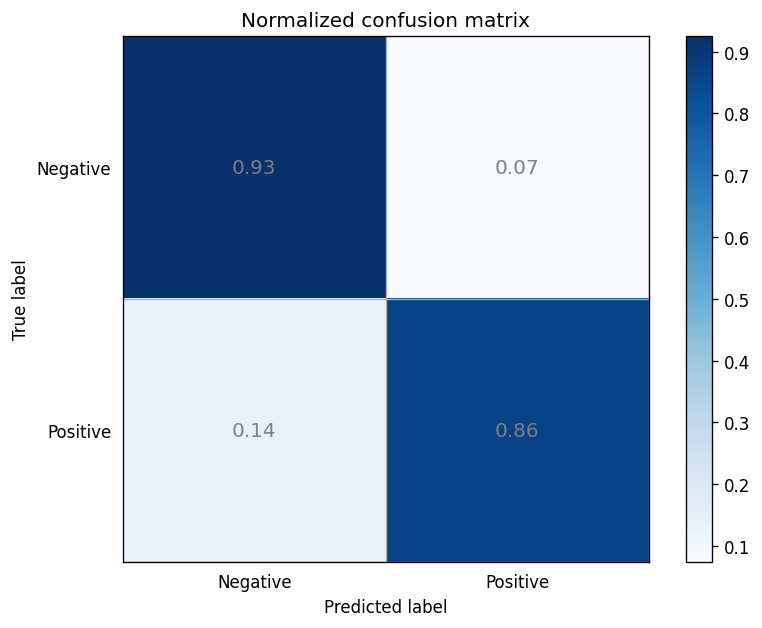

<Figure size 432x288 with 0 Axes>

In [0]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

labels = ['Negative', 'Positive']
tick_marks = np.array(range(len(labels))) + 0.5

def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.binary):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(labels)))
    plt.xticks(xlocations, labels)
    plt.yticks(xlocations, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

cm = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print (cm_normalized)
plt.figure(figsize=(8, 6), dpi=120)

ind_array = np.arange(len(labels))
x, y = np.meshgrid(ind_array, ind_array)

for x_val, y_val in zip(x.flatten(), y.flatten()):
    c = cm_normalized[y_val][x_val]
#     if c > 0.01:
    plt.text(x_val, y_val, "%0.2f" % (c,), color='grey', fontsize=12, va='center', ha='center')
# offset the tick
plt.gca().set_xticks(tick_marks, minor=True)
plt.gca().set_yticks(tick_marks, minor=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.grid(True, which='minor', linestyle='-')
plt.gcf().subplots_adjust(bottom=0.15)

plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
# show confusion matrix
plt.savefig('/content/svm_confusion_matrix.png', format='png')

## Prediction on collected reviews at the airport 

In [0]:
def getPrediction(in_sentences):
  labels = ["Negative", "Positive"]
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] # here, "" is just a dummy label
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(sentence, prediction['probabilities'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

In [0]:
import csv

reviews = []

with open("/content/drive/My Drive/data/total_reviews.csv", "r") as f:
    reader = csv.reader(f, delimiter=",")
    for row in reader:
        name = row[0]
        raw_review = row[1]
        reviews.append(raw_review)

In [0]:
len(reviews)

1338

In [0]:
review_predictions = getPrediction(reviews)

INFO:tensorflow:Writing example 0 of 1338


INFO:tensorflow:Writing example 0 of 1338


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] if you haven ' t been to the international airport in rio de janeiro in a while , it is a lot different than it used to be . gone are the days of the two horrible restaurants and one duty free shop . there is a decent restaurant after immigration called a said ##eira . nice drink list with some traditional brazilian dishes . a good way to spend an hour ( or two ) while you ' re waiting for your flight . " i would like to give - 5 star if possible . terrible service ever ! ! ! ! we were sitting for a long time waiting for service and when the waiter came he didn ' t even look into [SEP]


INFO:tensorflow:tokens: [CLS] if you haven ' t been to the international airport in rio de janeiro in a while , it is a lot different than it used to be . gone are the days of the two horrible restaurants and one duty free shop . there is a decent restaurant after immigration called a said ##eira . nice drink list with some traditional brazilian dishes . a good way to spend an hour ( or two ) while you ' re waiting for your flight . " i would like to give - 5 star if possible . terrible service ever ! ! ! ! we were sitting for a long time waiting for service and when the waiter came he didn ' t even look into [SEP]


INFO:tensorflow:input_ids: 101 2065 2017 4033 1005 1056 2042 2000 1996 2248 3199 1999 5673 2139 11497 1999 1037 2096 1010 2009 2003 1037 2843 2367 2084 2009 2109 2000 2022 1012 2908 2024 1996 2420 1997 1996 2048 9202 7884 1998 2028 4611 2489 4497 1012 2045 2003 1037 11519 4825 2044 7521 2170 1037 2056 21302 1012 3835 4392 2862 2007 2070 3151 6142 10447 1012 1037 2204 2126 2000 5247 2019 3178 1006 2030 2048 1007 2096 2017 1005 2128 3403 2005 2115 3462 1012 1000 1045 2052 2066 2000 2507 1011 1019 2732 2065 2825 1012 6659 2326 2412 999 999 999 999 2057 2020 3564 2005 1037 2146 2051 3403 2005 2326 1998 2043 1996 15610 2234 2002 2134 1005 1056 2130 2298 2046 102


INFO:tensorflow:input_ids: 101 2065 2017 4033 1005 1056 2042 2000 1996 2248 3199 1999 5673 2139 11497 1999 1037 2096 1010 2009 2003 1037 2843 2367 2084 2009 2109 2000 2022 1012 2908 2024 1996 2420 1997 1996 2048 9202 7884 1998 2028 4611 2489 4497 1012 2045 2003 1037 11519 4825 2044 7521 2170 1037 2056 21302 1012 3835 4392 2862 2007 2070 3151 6142 10447 1012 1037 2204 2126 2000 5247 2019 3178 1006 2030 2048 1007 2096 2017 1005 2128 3403 2005 2115 3462 1012 1000 1045 2052 2066 2000 2507 1011 1019 2732 2065 2825 1012 6659 2326 2412 999 999 999 999 2057 2020 3564 2005 1037 2146 2051 3403 2005 2326 1998 2043 1996 15610 2234 2002 2134 1005 1056 2130 2298 2046 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] staff was good but received a to ##tino ##s pizza and a weak margarita . quality can be better . [SEP]


INFO:tensorflow:tokens: [CLS] staff was good but received a to ##tino ##s pizza and a weak margarita . quality can be better . [SEP]


INFO:tensorflow:input_ids: 101 3095 2001 2204 2021 2363 1037 2000 25690 2015 10733 1998 1037 5410 24570 1012 3737 2064 2022 2488 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 3095 2001 2204 2021 2363 1037 2000 25690 2015 10733 1998 1037 5410 24570 1012 3737 2064 2022 2488 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] i had an excellent meal before a long flight to the u . s . the chu ##rro ##s were especially delicious and a must try . math ##eus is a great server and took excellent care of us . [SEP]


INFO:tensorflow:tokens: [CLS] i had an excellent meal before a long flight to the u . s . the chu ##rro ##s were especially delicious and a must try . math ##eus is a great server and took excellent care of us . [SEP]


INFO:tensorflow:input_ids: 101 1045 2018 2019 6581 7954 2077 1037 2146 3462 2000 1996 1057 1012 1055 1012 1996 14684 18933 2015 2020 2926 12090 1998 1037 2442 3046 1012 8785 10600 2003 1037 2307 8241 1998 2165 6581 2729 1997 2149 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1045 2018 2019 6581 7954 2077 1037 2146 3462 2000 1996 1057 1012 1055 1012 1996 14684 18933 2015 2020 2926 12090 1998 1037 2442 3046 1012 8785 10600 2003 1037 2307 8241 1998 2165 6581 2729 1997 2149 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] math ##eus served us tonight and was wonderful . the food was excellent , fresh and prompt . will be back when we travel to rio . [SEP]


INFO:tensorflow:tokens: [CLS] math ##eus served us tonight and was wonderful . the food was excellent , fresh and prompt . will be back when we travel to rio . [SEP]


INFO:tensorflow:input_ids: 101 8785 10600 2366 2149 3892 1998 2001 6919 1012 1996 2833 2001 6581 1010 4840 1998 25732 1012 2097 2022 2067 2043 2057 3604 2000 5673 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 8785 10600 2366 2149 3892 1998 2001 6919 1012 1996 2833 2001 6581 1010 4840 1998 25732 1012 2097 2022 2067 2043 2057 3604 2000 5673 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] two great app ##eti ##zers on there . ambient music was boss ##a nova , i really enjoyed ! math ##eus thanks for seeing me so quickly and good hospitality . [SEP]


INFO:tensorflow:tokens: [CLS] two great app ##eti ##zers on there . ambient music was boss ##a nova , i really enjoyed ! math ##eus thanks for seeing me so quickly and good hospitality . [SEP]


INFO:tensorflow:input_ids: 101 2048 2307 10439 20624 16750 2006 2045 1012 17093 2189 2001 5795 2050 6846 1010 1045 2428 5632 999 8785 10600 4283 2005 3773 2033 2061 2855 1998 2204 15961 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2048 2307 10439 20624 16750 2006 2045 1012 17093 2189 2001 5795 2050 6846 1010 1045 2428 5632 999 8785 10600 4283 2005 3773 2033 2061 2855 1998 2204 15961 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from BERT/model.ckpt-156


INFO:tensorflow:Restoring parameters from BERT/model.ckpt-156


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [0]:
pred = review_predictions

In [0]:
output = ""

for i, result in enumerate(pred):
  output += result[2] + "\n"

with open('/content/drive/My Drive/data/review_polarity.csv', 'w') as f:
  f.write(output)

In [0]:
reviews_to_restaurant = {}
currentName = None
with open("/content/drive/My Drive/data/total_reviews.csv", "r") as f:
    reader = csv.reader(f, delimiter=",")
    for row in reader:
        name = row[0]
        review = row[1]

        if name != "":
            currentName = name
        
        reviews_to_restaurant[review] = currentName

In [0]:
restaurant_result = {}
cnt = 0
for i, p in enumerate(pred):
  review = p[0]
  polarity = p[2]

  if review in reviews_to_restaurant:
    name = reviews_to_restaurant[review]
  
    if name not in restaurant_result:
      restaurant_result[name] = {
          "polarity" : [0, 0],
          "positive_reviews" : [],
          "negative_reviews" : []
      }

    if polarity == "Negative":
      restaurant_result[name]["polarity"][0] += 1
      restaurant_result[name]["negative_reviews"].append(review)
    elif polarity == "Positive":
      restaurant_result[name]["polarity"][1] += 1
      restaurant_result[name]["positive_reviews"].append(review)
    
    cnt += 1

print(cnt)
restaurant_result

1338


{'A Saideira': {'negative_reviews': ['If you haven\'t been to the international airport in Rio de Janeiro in a while, it is a lot different than it used to be. Gone are the days of the two horrible restaurants and one duty free shop. There is a decent restaurant after immigration called A Saideira. Nice drink list with some traditional Brazilian dishes. A good way to spend an hour (or two) while you\'re waiting for your flight.\n"I would like to give -5 star if possible.\nTerrible service ever!!!! We were sitting for a long time waiting for service and when the waiter came he didn\'t even look into our face.\nThe food had a weird smell and we decided not to eat that.\nNobody came back to the table and we had to go to the cashier to pay.\nExpensive place for crappy food and service.\nDon\'t go to this place!!"\nThe place has a beautiful and colorful ambiance, although the food is mediocre. The " coxinhas " (chicken appetizer) was filled of dough and no trace of chicken. Brazilian food i

In [0]:
output = "name, negative, positive \n"

for name in restaurant_result:
  output += name + "," + str(restaurant_result[name]["polarity"][0]) + "," + str(restaurant_result[name]["polarity"][1]) + "\n"

with open('/content/drive/My Drive/data/restaurant_review_polarity.csv', 'w') as f:
  f.write(output)

In [0]:
import json 
with open('/content/drive/My Drive/data/restaurant_review_polarity.json', 'w') as f:
  f.write(json.dumps(restaurant_result, indent=4))

## Analyze Positive and Negative words from reviews

In [0]:
positive_path = "/content/drive/My Drive/data/opinion-lexicon-English/positive-words.txt"
negative_path = "/content/drive/My Drive/data/opinion-lexicon-English/negative-words.txt"

rst = []
pos_words = set()
neg_words = set()
# positive words
posFiles = open(positive_path, 'r')
lines = posFiles.readlines()

for line in lines:
    line = line.strip('\n')
    line = line.strip('\t')

    if line != "":
        pos_words.add(line)

# negative words
    negFiles = open(negative_path, 'r')
    lines = negFiles.readlines()

    for line in lines:
        line = line.strip('\n')
        line = line.strip('\t')
        
        if line != "":
            neg_words.add(line)

In [0]:
for name in restaurant_result:
  restaurant_result[name]["positive_words"] = []
  pos_cnts = {}
  pos_total_cnt = 0
  pos_reviews = restaurant_result[name]["positive_reviews"]

  restaurant_result[name]["negative_words"] = []
  neg_cnts = {}
  neg_reviews = restaurant_result[name]["negative_reviews"]
  neg_total_cnt = 0

  for i in range(len(pos_reviews)):
    raw_review = pos_reviews[i]
    new_review = ""

    for j in range(len(raw_review)):
      if raw_review[j].isalnum():
          new_review += raw_review[j]
      else:
          new_review += " "
    
    tokens = new_review.split(" ")

    for j in range(len(tokens)):
        word = tokens[j].lower().strip()
        if not word or word == "" or word == " ":
            continue

        if word in pos_words:
            if word not in pos_cnts:
                pos_cnts[word] = 0
            pos_cnts[word] += 1
            pos_total_cnt += 1

  for i in range(len(neg_reviews)):
    raw_review = neg_reviews[i]
    new_review = ""

    for j in range(len(raw_review)):
      if raw_review[j].isalnum():
          new_review += raw_review[j]
      else:
          new_review += " "
    
    tokens = new_review.split(" ")

    for j in range(len(tokens)):
        word = tokens[j].lower().strip()
        if not word or word == "" or word == " ":
            continue

        if word in neg_words:
            if word not in neg_cnts:
                neg_cnts[word] = 0
            neg_cnts[word] += 1
            neg_total_cnt += 1

  for word in pos_cnts:
      restaurant_result[name]["positive_words"].append({
          "name" : word,
          "value" : pos_cnts[word] / (pos_total_cnt) * 100
      })
  for word in neg_cnts:
      restaurant_result[name]["negative_words"].append({
          "name" : word,
          "value" : neg_cnts[word] / (neg_total_cnt) * 100
      })

In [0]:
import json 
with open('/content/drive/My Drive/data/restaurant_review_polarity.json', 'w') as f:
  f.write(json.dumps(restaurant_result, indent=4))